# Detectron2 Panoptic Segmentation
<b>Overview</b>
* Train a panoptic segmentation model using detecton2
* Convert Labelbox data into the mscoco panoptic format
* Upload predictions to the Labelbox model diagnostics tool
* Upload predictions for MAL to accelerate labeling efforts

### Usage
- <b>Model Training</b>:
  * Set a project ID containing polygons and segmentation labels
  * Polygons will train the instance segmentation head
  * Segmentation labels will train the semantic segmentation head
- <b>Diagnostics</b>:
  * No additional configuration is necessary. As long as the model has been   
- <b>MAL</b>:
  * Set a dataset ID for the dataset you would like to upload predictions to. A new project will automatically be created.
trained this will work.

### Suggested Workflow
* To get the most out of Labelbox, we suggest training a model on a small amount of data, exploring model performance using diagnostics, selecting a dataset using catalog to address model shortcomings, make any model architecture adjustments, and then upload predictions via MAL made on this new dataset for faster labeling.


<b>Setup</b>:
* This is the only section that needs to be configured.

In [1]:
API_KEY = None
# For training:
project_id = ""
# The model will make predictions on the following dataset 
# and upload predictions to a new project for model assisted labeling.
mal_dataset_id = ""

In [2]:
# Based on:
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=Ya5nEuMELeq8

In [3]:
!pip install -q torch \
                torchvision \
                git+https://github.com/cocodataset/panopticapi.git \
                'git+https://github.com/facebookresearch/detectron2.git'           
!pip install -q "git+https://github.com/Labelbox/labelbox-python@ms/coco#egg=labelbox[data]"

     |████████████████████████████████| 49 kB 3.4 MB/s 
     |████████████████████████████████| 74 kB 4.0 MB/s 
     |████████████████████████████████| 145 kB 63.4 MB/s 
     |████████████████████████████████| 130 kB 75.2 MB/s 
     |████████████████████████████████| 745 kB 60.0 MB/s 
     |████████████████████████████████| 743 kB 54.6 MB/s 
     |████████████████████████████████| 636 kB 63.8 MB/s 
     |████████████████████████████████| 112 kB 76.0 MB/s 
     |████████████████████████████████| 10.1 MB 12.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [4]:
import json
import os
import uuid
import random
import functools

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from shapely.geometry import MultiPolygon
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import torch
import requests

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_panoptic_separated
from detectron2.data.datasets import register_coco_instances,register_coco_panoptic
from detectron2.data.datasets.coco import load_coco_json
from detectron2.data.datasets.coco_panoptic import load_coco_panoptic_json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import Visualizer

from labelbox.schema.model import Model
from labelbox.data.metrics.group import get_label_pairs
from labelbox import LabelingFrontend, OntologyBuilder, Client
from labelbox.data.metrics.iou import data_row_miou
from labelbox.data.serialization import COCOConverter, NDJsonConverter
from labelbox.data.annotation_types import (
    Point,
    Polygon,
    Mask, 
    Label,
    Rectangle, 
    Polygon,
    LabelList,
    ImageData,
    MaskData,
    ObjectAnnotation
)
from labelbox.data.metrics import (
    feature_miou_metric, 
    feature_confusion_matrix_metric
)


with open('./coco_utils.py', 'w' ) as file:
    helper = requests.get("https://raw.githubusercontent.com/Labelbox/labelbox-python/ms/coco/examples/integrations/detectron2/coco_utils.py").text
    file.write(helper)

from coco_utils import visualize_coco_examples, partition_coco, separate_coco_semantic_from_panoptic



In [5]:
client = Client(api_key = API_KEY)

## Optional Config:
* `project_id` - Indicates which project labels should be exported from.
* `mal_dataset_id` - Dataset to use for MAL. We will create a new project in this notebook.
* `image_root` - Where to write images to on disk
* `mask_root` - Where to write panoptic segmentation masks to on disk
* `seg_masks_root` - Where to write the semantic segmentation masks
* `train_json_instance_path` - Where the train partition of the coco instance data will be written
* `train_json_panoptic_path` - Where the train partition of the coco panoptic data will be written
* `test_json_instance_path` - Where the test partition of the coco instance data will be written
* `test_json_panoptic_path` - Where the test partition of the coco panoptic data will be written
* `train_test_split` - How much of the data to add to each parition (by percent)
* `model_zoo_config` - Detectron2 model config see more here : https://github.com/facebookresearch/detectron2/blob/master/detectron2/model_zoo/model_zoo.py 


In [6]:
image_root = "/tmp/images/"
mask_root = "/tmp/masks/"
seg_masks_root = "/tmp/segmentation"
train_json_instance_path = '/tmp/json_train_instance_annotations.json'
train_json_panoptic_path = "/tmp/json_train_panoptic.json"
test_json_instance_path = '/tmp/json_test_instance_annotations.json'
test_json_panoptic_path = "/tmp/json_test_panoptic.json"
train_test_split = [0.8, 0.2]
model_zoo_config = "COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml"
train_ds_name = "custom_coco_train"
test_ds_name = "custom_coco_test"

model_name = "detectron_panoptic_model"

proj = client.get_project(project_id)
labels = proj.label_generator().as_list()


In [7]:
# Set some labels aside for the val set.
raw_data = labels._data
labels = LabelList(raw_data[100:])
val_labels = LabelList(raw_data[:100]) 

* Download images locally
* This is only required as part of detectrons usage of coco data. Since it requires both the panoptic and object formats.
* The reason is that the image paths need to be the same somehow. 
To achieve this we are just setting the file path explicitly ahead of time.

In [8]:
if not os.path.exists(image_root):
    os.mkdir(image_root)

def set_image_path(label, idx):
    file_path = os.path.join(image_root, f"{idx}.jpg")
    Image.fromarray(label.data.value).save(file_path)
    label.data.file_path = file_path
    
futures = []
with ThreadPoolExecutor(max_workers=12) as executor:
    for idx, label in enumerate(labels):
        futures.append(executor.submit(set_image_path, label, idx))
        
    for _ in tqdm(as_completed(futures)):
        _.result()
  

25it [00:08,  3.04it/s]


In [9]:

# We need the order to be the same to know that the images are the same..
instance_labels = []
for idx, label in enumerate(labels):
    instance_labels.append(
        Label(
            data = label.data,
            annotations = [annot for annot in label.annotations if isinstance(annot.value, Polygon)]
        )
    )

# This is a lot faster if the objects are polygons
coco_instance = COCOConverter.serialize_instances(
    labels = instance_labels, 
    image_root = image_root,
    ignore_existing_data = True
)

panoptic_labels = []
for idx, label in enumerate(labels):
    panoptic_labels.append(
        Label(
            data = label.data,
            annotations = [annot for annot in label.annotations if isinstance(annot.value, Mask)]
            )
    )   
 

# For instances, detectron requires object format..
coco_panoptic = COCOConverter.serialize_panoptic(
    labels = panoptic_labels,
    image_root = image_root,
    mask_root = mask_root,
    all_stuff = True,
    ignore_existing_data = True
)


for category in coco_panoptic['categories']:
    category['id'] += len(coco_instance['categories'])

for annotation in coco_panoptic['annotations']:
    for segment_info in annotation['segments_info']:
        segment_info['category_id'] += len(coco_instance['categories'])

things_classes = []

train_partition, test_partition = partition_coco(coco_instance, coco_panoptic, [0.8, 0.2])

for parition, instance_name, panoptic_name in [[train_partition, train_json_instance_path, train_json_panoptic_path], [test_partition, test_json_instance_path, test_json_panoptic_path]]:
    with open(instance_name, 'w') as file:
        json.dump(parition['instance'], file)
    with open(panoptic_name, 'w') as file:
        json.dump(parition['panoptic'], file)




25it [00:01, 19.05it/s]
25it [01:15,  3.01s/it]


In [10]:
# Maps the coco format of the seg masks to the expected format for detectron
separate_coco_semantic_from_panoptic(train_json_panoptic_path, mask_root, seg_masks_root, coco_panoptic['categories'] + coco_instance['categories'])

20it [00:03,  5.13it/s]


In [11]:
data_name = f'{train_ds_name}_separated'
register_coco_panoptic_separated(train_ds_name,{}, 
        image_root, 
        mask_root, train_json_panoptic_path, 
        seg_masks_root,train_json_instance_path)

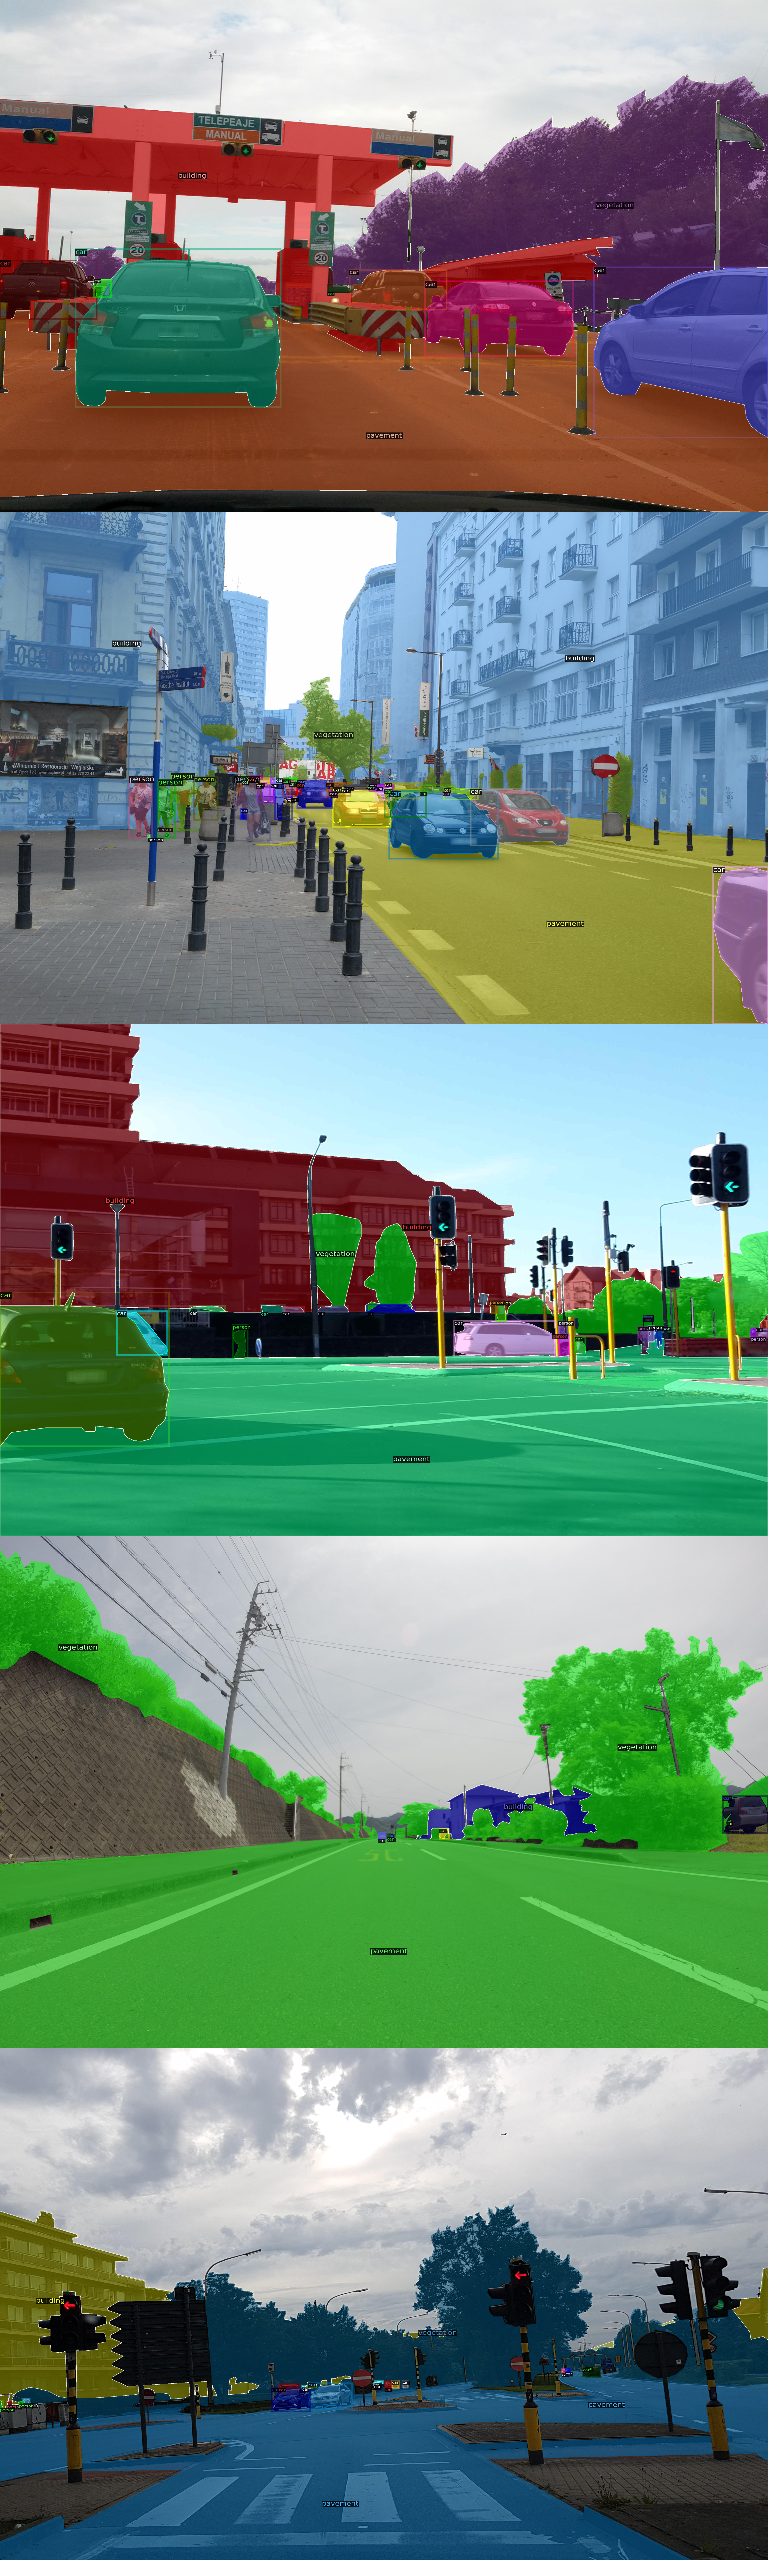

In [12]:

def clear_metadata(dataset_name):
    if hasattr( MetadataCatalog.get(dataset_name), 'stuff_classes'):
        del MetadataCatalog.get(dataset_name).stuff_classes
    if hasattr( MetadataCatalog.get(dataset_name), 'thing_classes'):
        del MetadataCatalog.get(dataset_name).thing_classes

    if hasattr( MetadataCatalog.get(dataset_name), 'thing_dataset_id_to_contiguous_id'):
        del MetadataCatalog.get(dataset_name).thing_dataset_id_to_contiguous_id
    if hasattr( MetadataCatalog.get(dataset_name), 'stuff_dataset_id_to_contiguous_id'):
        del MetadataCatalog.get(dataset_name).stuff_dataset_id_to_contiguous_id


def build_metadata(dataset_name):   
    clear_metadata(dataset_name)
    MetadataCatalog.get(data_name).set(
        thing_classes={k['id']: k['name'] for i, k in enumerate(coco_instance['categories'])},
        # stuff_classes={i : k['name'] for i, k in enumerate(coco_panoptic['categories'])},
        stuff_classes={k['id'] : k['name'] for i, k in enumerate(coco_panoptic['categories'])},
        thing_dataset_id_to_contiguous_id = {k['id']: k['id'] for i, k in enumerate(coco_instance['categories'])}, 
        # stuff_dataset_id_to_contiguous_id = {k['id']: i for i, k in enumerate(coco_panoptic['categories'])}
        stuff_dataset_id_to_contiguous_id = {k['id']: k['id'] for i, k in enumerate(coco_panoptic['categories'])}
    )

build_metadata(data_name)
test_json_instance = load_coco_json(test_json_instance_path, image_root)
test_json_panoptic = load_coco_panoptic_json(test_json_panoptic_path, image_root, mask_root ,MetadataCatalog.get(data_name).as_dict())
visualize_coco_examples(MetadataCatalog.get(data_name), test_json_instance,test_json_panoptic, resize_dims = (768, 512), max_images = 40)

In [13]:
clear_metadata(data_name)
MetadataCatalog.get(data_name).set(
        thing_classes=[k['name'] for i, k in enumerate(coco_instance['categories'])],
        stuff_classes = [k['name'] for i, k in enumerate(coco_panoptic['categories'])]
)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_zoo_config))
cfg.DATASETS.TRAIN = (data_name,)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_zoo_config) 
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES =len(coco_instance['categories']) 
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = len(coco_panoptic['categories']) + 1
cfg.INPUT.MASK_FORMAT = "bitmask"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/15 12:47:46 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
model_final_dbfeb4.pkl: 184MB [00:03, 47.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.b

[09/15 12:47:51 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)

[09/15 12:48:02 d2.utils.events]:  eta: 0:00:26  iter: 19  total_loss: 6.528  loss_sem_seg: 2.82  loss_rpn_cls: 0.1179  loss_rpn_loc: 0.493  loss_cls: 1.457  loss_box_reg: 0.8083  loss_mask: 0.6864  time: 0.4074  data_time: 0.2200  lr: 0.00019081  max_mem: 1857M
[09/15 12:48:11 d2.utils.events]:  eta: 0:00:21  iter: 39  total_loss: 2.956  loss_sem_seg: 0.3267  loss_rpn_cls: 0.09758  loss_rpn_loc: 0.447  loss_cls: 0.6932  loss_box_reg: 0.7776  loss_mask: 0.5941  time: 0.4114  data_time: 0.0793  lr: 0.00039061  max_mem: 1936M
[09/15 12:48:19 d2.utils.events]:  eta: 0:00:14  iter: 59  total_loss: 2.369  loss_sem_seg: 0.2144  loss_rpn_cls: 0.09306  loss_rpn_loc: 0.4839  loss_cls: 0.5  loss_box_reg: 0.7751  loss_mask: 0.4428  time: 0.4132  data_time: 0.0960  lr: 0.00059041  max_mem: 1939M
[09/15 12:48:27 d2.utils.events]:  eta: 0:00:07  iter: 79  total_loss: 2.128  loss_sem_seg: 0.1537  loss_rpn_cls: 0.05618  loss_rpn_loc: 0.4794  loss_cls: 0.3576  loss_box_reg: 0.6835  loss_mask: 0.3823  t

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

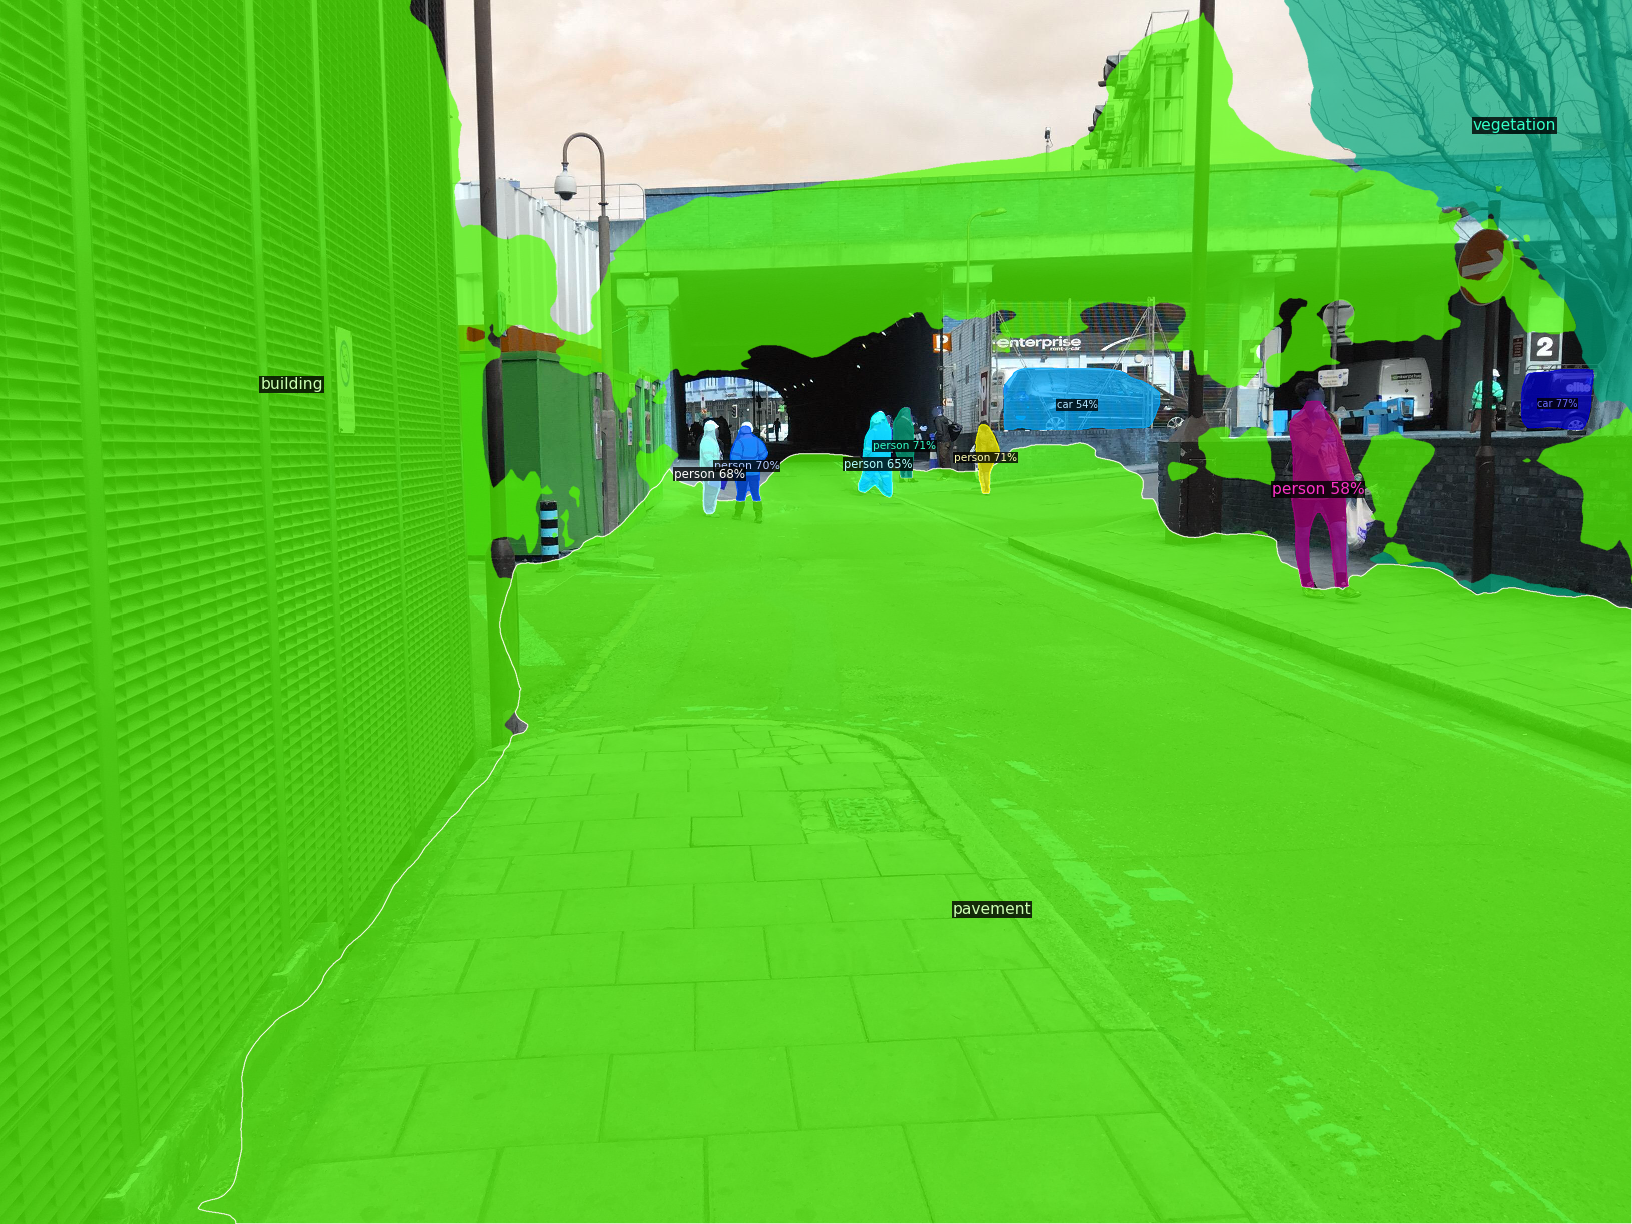

In [15]:
clear_metadata(data_name)
MetadataCatalog.get(data_name).set(
        thing_classes=[k['name'] for i, k in enumerate(coco_instance['categories'])] + [k['name'] for i, k in enumerate(coco_panoptic['categories'])],
        stuff_classes = ["background"] +  [k['name'] for i, k in enumerate(coco_panoptic['categories'])] 
)

im = np.array(Image.open('/tmp/images/12.jpg'))
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(data_name), scale=0.5)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# panoptic segmentation result
Image.fromarray(v.get_image())

## Make Predictions
* Create helper function for making inferences
* Predict and upload for model assisted labeling
* Predict and upload for model diagnostics

In [16]:



def get_label(image):
    res = predictor(image.value)
    mask, seg_info = res['panoptic_seg']
    seg_mask = mask.cpu().numpy()
    annotations = []
    for info in seg_info:
        mask_data = MaskData.from_2D_arr( (seg_mask == info['id']).astype(np.uint8))
        # Convert to bytes to reduce memory requirements
        mask_data.im_bytes = mask_data.np_to_bytes(mask_data.arr)
        mask_data.arr = None
        mask = Mask(mask = mask_data, color = (1,1,1))
        if info['isthing']:
            # Convert instances into polygons
            geom = mask.shapely.buffer(0).simplify(3)
            if isinstance(geom, MultiPolygon):
                geom = geom.convex_hull
            annot = Polygon(points = [Point(x=x,y=y) for x,y in list(geom.exterior.coords)])
        else:
            annot = mask

        if info['isthing']:
            name = MetadataCatalog.get(data_name).thing_classes[info['category_id']]
        else:
            name = MetadataCatalog.get(data_name).stuff_classes[info['category_id']]
        annotations.append(ObjectAnnotation(
            name = name,
            value = annot,
        ))
    return Label(
          data = image,
          annotations = annotations      
      )

# Allows us to upload local images and masks to labelbox   
signer = lambda _bytes: client.upload_data(content=_bytes, sign=True)

## Upload to Diagnostics

In [17]:
labels_mea = LabelList()
with ThreadPoolExecutor(4) as executor:
    futures = [executor.submit(get_label,label.data) for label in val_labels]
    for future in tqdm(as_completed(futures)):
        labels_mea.append(future.result())

labels_mea.add_url_to_masks(signer) \
      .add_url_to_data(signer) \
      .assign_feature_schema_ids(OntologyBuilder.from_project(proj))

100it [06:42,  4.03s/it]
100it [00:19,  5.13it/s]
100it [00:00, 115992.92it/s]


In [18]:
# If the model already exists fetch it with the following:

model = next(client.get_models(where = Model.name == model_name), None)
if model is None:
    model = client.create_model(model_name, ontology_id=proj.ontology().uid)


# Increment model run version if it exists. Otherwise use the initial 0.0.0
model_run_names = [model_run.name for model_run in model.model_runs()]
if len(model_run_names):
    model_run_names.sort(key=lambda s: [int(u) for u in s.split('.')])
    latest_model_run_name = model_run_names[-1]
    model_run_suffix = int(latest_model_run_name.split('.')[-1]) + 1
    model_run_name = ".".join([*latest_model_run_name.split('.')[:-1], str(model_run_suffix)])
else:
    model_run_name = "0.0.0"

print(f"Model Name: {model.name} | Model Run Version : {model_run_name}")
model_run = model.create_model_run(model_run_name)
model_run.upsert_labels([label.uid for label in val_labels])

Model Name: detectron_panoptic_model | Model Run Version : 0.0.1


True

In [19]:
pairs = get_label_pairs(val_labels, labels_mea, filter_mismatch = True)
idx =0 
for (ground_truth, prediction) in pairs.values():
    print(idx)
    idx += 1
    metrics = []
    metrics.extend(feature_miou_metric(ground_truth.annotations, prediction.annotations))
    metrics.extend(feature_confusion_matrix_metric(ground_truth.annotations, prediction.annotations))    
    prediction.annotations.extend(metrics)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [20]:
upload_task = model_run.add_predictions(f'diagnostics-import-{uuid.uuid4()}', NDJsonConverter.serialize(labels_mea))
upload_task.wait_until_done()
print(upload_task.state)
print(upload_task.errors)

AnnotationImportState.FINISHED
[]


In [21]:

for idx, annotation_group in enumerate(model_run.annotation_groups()):
    if idx == 5:
        break
    print(annotation_group.url)

https://app.labelbox.com/models/9c50e320-56e9-0558-a77e-c6d3b2f91c6d/9c50ea2b-146a-0113-57d5-a05450fb7191/AllDatarowsSlice/00ab7861-59f5-4012-aac8-d353767dae01?view=carousel
https://app.labelbox.com/models/9c50e320-56e9-0558-a77e-c6d3b2f91c6d/9c50ea2b-146a-0113-57d5-a05450fb7191/AllDatarowsSlice/01932c1b-66ed-448f-891a-2b9cfcaee0d2?view=carousel
https://app.labelbox.com/models/9c50e320-56e9-0558-a77e-c6d3b2f91c6d/9c50ea2b-146a-0113-57d5-a05450fb7191/AllDatarowsSlice/0585aeee-db0a-49ec-9844-0be3c806ee5d?view=carousel
https://app.labelbox.com/models/9c50e320-56e9-0558-a77e-c6d3b2f91c6d/9c50ea2b-146a-0113-57d5-a05450fb7191/AllDatarowsSlice/0a7a843a-6569-4744-b8af-54d48916dea7?view=carousel
https://app.labelbox.com/models/9c50e320-56e9-0558-a77e-c6d3b2f91c6d/9c50ea2b-146a-0113-57d5-a05450fb7191/AllDatarowsSlice/0cf0a42d-be65-4b1e-aa90-15165b38ea91?view=carousel


## Dataset Selection
* Explore model performance by clicking on the links above
* Determine what data the model needs to improve
* Use metadata and other features in [Catalog](https://app.labelbox.com/catalog) to select the highest valued data to get labeled.
  * If necessary update `mal_dataset_id` update this variable to point to this new dataset


## Upload for Model Assisted Labeling

In [22]:
# Some additional unlabeled data rows
dataset = client.get_dataset(mal_dataset_id) 


# Use ThreadPoolExecutor to parallelize image downloads.
# This is still a bit slow due to the amount of processing for each data row.
# For larger datasets this has to leverage multiprocessing.


labels_mal = LabelList()
with ThreadPoolExecutor(4) as executor:
    data_rows = dataset.data_rows()
    images = [ImageData(url = data_row.row_data, uid = data_row.uid, external_id = data_row.external_id) for data_row in data_rows]
    futures = [executor.submit(get_label, image) for idx, image in enumerate(images) if idx < 25]
    for future in tqdm(as_completed(futures)):
        labels_mal.append(future.result())



25it [00:05,  4.64it/s]


In [23]:
project = client.create_project(name = "detectron_labels")
editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == 'editor'))
project.setup(editor, labels_mal.get_ontology().asdict())
project.enable_model_assisted_labeling()
project.datasets.connect(dataset)


In [24]:
    
labels_mal.add_url_to_masks(signer) \
      .add_url_to_data(signer) \
      .assign_feature_schema_ids(OntologyBuilder.from_project(project))

ndjsons = list(NDJsonConverter.serialize(labels_mal))
upload_task = project.upload_annotations(name=f"upload-job-{uuid.uuid4()}",
                                         annotations=ndjsons,
                                         validate=False)
# Wait for upload to finish
upload_task.wait_until_done()
# Review the upload status
print(upload_task.errors)

25it [00:04,  5.99it/s]
25it [00:00, 104439.84it/s]


[]
